# Data Science

We will train 4 different models in 2 experiments, and for each on eadjuste hiperparameters. Also, we will load every run into mlflow.

**Models**
* Logistic Regression
* Random Forest Classifier
* XGBoost Classifier
* KNN Classifier

Eliminar 7 commits previos

>> git reset --soft HEAD~7

### Libraries

In [1]:
from datetime import datetime
from pprint import pprint

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.ensemble import BalancedRandomForestClassifier
from mlflow.models import infer_signature
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    accuracy_score,
    average_precision_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    ParameterSampler,
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


### Load data

In [2]:
# Comment once you run this line
%load_ext kedro.ipython
#%reload_kedro

[06/13/25 21:38:03] INFO     Using 'c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo               __init__.py:272
                             semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\kedro\f                
                             ramework\project\rich_logging.yml' as logging configuration.                          

                    INFO     Registered line magic '%reload_kedro'                                   __init__.py:63

                    INFO     Registered line magic '%load_node'                                      __init__.py:65

                    INFO     Resolved project path as: c:\Users\Esteban\Documents\. Clases_Tec\8.   __init__.py:180
                             Octavo semestre\_Proyecto\kProject\tcaproject.                                        
                             To set a different path, run '%reload_kedro <project_root>'                           

c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\mlflow\pyfunc\utils\data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


[06/13/25 21:38:06] INFO     Registering new custom resolver: 'km.random_name'                    mlflow_hook.py:65

                    INFO     The 'tracking_uri' key in mlflow.yml is relative            kedro_mlflow_config.py:293
                             ('server.mlflow_(tracking|registry)_uri = mlruns'). It is                             
                             converted to a valid uri:                                                             
                             'file:///C:/Users/Esteban/Documents/.%20Clases_Tec/8.%20Oct                           
                             avo%20semestre/_Proyecto/kProject/tcaproject/mlruns'                                  

[06/13/25 21:38:07] INFO     Kedro is sending anonymous usage data with the sole purpose of improving plugin.py:233
                             the product. No personal data or IP addresses are stored on our side. If              
                             you want to opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK`              
                             environment variables, or create a `.telemetry` file in the current                   
                             working directory with the contents `consent: false`. Read more at                    
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

[06/13/25 21:38:08] INFO     Kedro project tcaProject                                               __init__.py:146

                    INFO     Defined global variable 'context', 'session', 'catalog' and            __init__.py:147
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        __init__.py:153

In [3]:
df_exp1 = catalog.load("reservaciones_exp1") # type: ignore # noqa: F821
df_exp2 = catalog.load("reservaciones_exp2") # type: ignore # noqa: F821

[06/13/25 21:38:10] INFO     Loading data from reservaciones_exp1 (ParquetDataset)...           data_catalog.py:403

[06/13/25 21:38:11] INFO     Loading data from reservaciones_exp2 (ParquetDataset)...           data_catalog.py:403

---
---


### EDA

In [4]:
df_exp1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202491 entries, 0 to 203001
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   numero_personas                202491 non-null  float64
 1   numero_adultos                 202491 non-null  float64
 2   numero_menores                 202491 non-null  float64
 3   numero_noches                  202491 non-null  float64
 4   total_habitaciones             202491 non-null  float64
 5   reservacion_pendiente          202491 non-null  float64
 6   total_tarifa                   202491 non-null  float64
 7   reservacion                    202491 non-null  float64
 8   cancelacion                    202491 non-null  float64
 9   dias_llegada-reservacion       202491 non-null  float64
 10  dias_salida-llegada            202491 non-null  float64
 11  nombre_agencia_te              202491 non-null  float64
 12  ciudad_agencia_te              2024

In [5]:
df_exp2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199813 entries, 0 to 203001
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   nombre_paquete          199813 non-null  float64
 1   ciudad_agencia          199813 non-null  float64
 2   nombre_tipo_habitacion  199813 non-null  float64
 3   nombre_canal            199813 non-null  float64
 4   nombre_estado           199813 non-null  float64
 5   cancelacion             199813 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 10.7 MB


In [6]:
print(df_exp1.isna().sum().sum())
print(df_exp2.isna().sum().sum())

0
0


**Correlation plots**

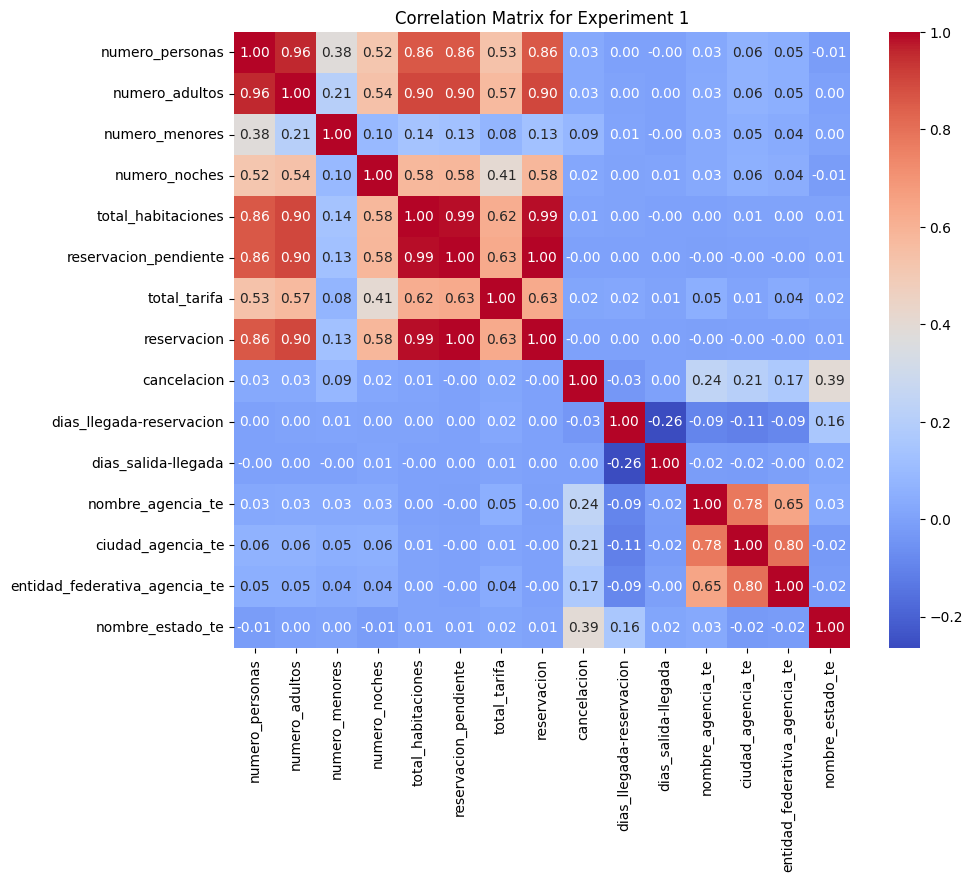

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_exp1.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix for Experiment 1")
plt.show()

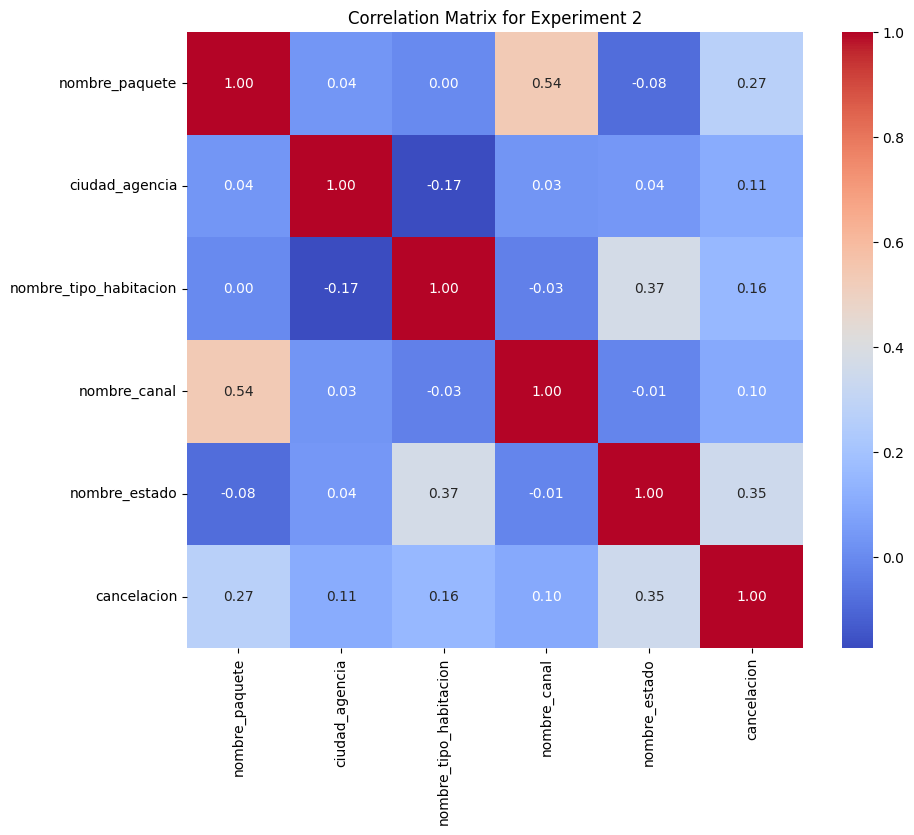

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_exp2.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix for Experiment 2")
plt.show()

**Violin plots**

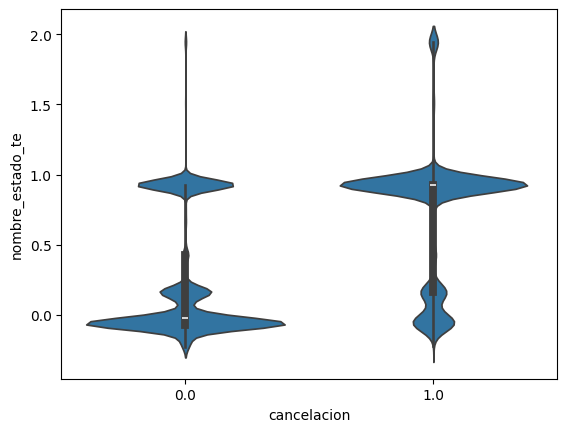

In [9]:
# Violint plot for each variable by cancelation
plt.figure()
sns.violinplot(x="cancelacion", y="nombre_estado_te", data=df_exp1)
plt.show()

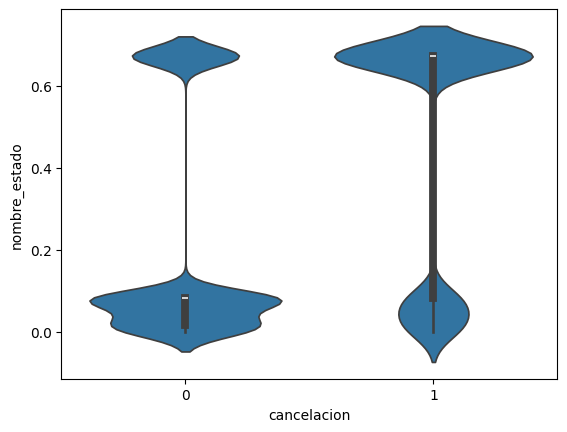

In [10]:
# Violint plot for each variable by cancelation
plt.figure()
sns.violinplot(x="cancelacion", y="nombre_estado", data=df_exp2)
plt.show()

---
---

### Train models and log into MLflow

**Train model: Experiment1**

In [11]:
# Define the target variable and independent variables
X = df_exp1.drop('cancelacion', axis=1)
y = df_exp1['cancelacion']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define logistic regression model
params = {
    'class_weight': 'balanced',
    'random_state': 42
    }

lr = LogisticRegression(**params)

lr.fit(X_train, y_train)

# Evaluation
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['No Cancellation', 'Cancellation']))  # noqa: T201

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
y_scores = lr.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(y_test, y_scores)
accuracy = accuracy_score(y_test, y_pred)

                 precision    recall  f1-score   support

No Cancellation       0.95      0.79      0.86     33896
   Cancellation       0.42      0.77      0.54      6603

       accuracy                           0.79     40499
      macro avg       0.68      0.78      0.70     40499
   weighted avg       0.86      0.79      0.81     40499



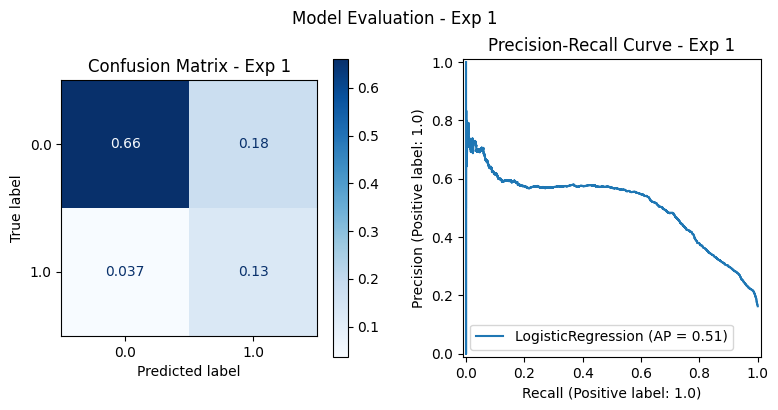

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test, normalize='all', cmap='Blues', ax=ax1)
ax1.set_title("Confusion Matrix - Exp 1")

PrecisionRecallDisplay.from_estimator(lr, X_test, y_test, ax=ax2)
ax2.set_title("Precision-Recall Curve - Exp 1")

plt.suptitle("Model Evaluation - Exp 1")

plt.tight_layout()  # Ajusta para que no se solapen los títulos

plt.savefig("model_evaluation_exp1.png")
plt.show()


**Log model: Experiment 1**

In [13]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("Experiment 1")

# Start an MLflow run
with mlflow.start_run():
    # Log the dataset
    #mlflow.log_artifact(datasets.load_iris())

    # Log the hyperparameters
    mlflow.log_params(params)

    # Log metrics
    metrics = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "average_precision": average_precision,
        "accuracy": accuracy
    }

    mlflow.log_metrics(metrics)

    # Log plots
    mlflow.log_artifact("model_evaluation_exp1.png")

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Info", "Basic Logistic Regression Model on reservaciones_exp1")
    mlflow.set_tag("Model Type", "Logistic Regression")
    mlflow.set_tag("Dataset", "reservaciones_exp1.parquet")

    # Infer the model signature
    signature = infer_signature(X_train, lr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=lr,
        artifact_path="reservaciones_exp1_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="reservaciones_exp1_model"
    )

2025/06/08 15:03:55 INFO mlflow.tracking.fluent: Experiment with name 'Experiment 1' does not exist. Creating a new experiment.
c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Registered model 'reservaciones_exp1_model' already exists. Creating a new version of this model...
2025/06/08 15:04:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: reservaciones_exp1_model, version 7
Created version '7' of model 'reservaciones_exp1_model'.


🏃 View run secretive-trout-28 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/f4566a3c9ff44394a36010d7f925d40f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


**Train Model: Experment 2**

In [14]:
# Define the target variable and independent variables
X = df_exp2.drop('cancelacion', axis=1)
y = df_exp2['cancelacion']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define logistic regression model
params = {
    'class_weight': 'balanced',
    'random_state': 42
    }

lr = LogisticRegression(**params)

lr.fit(X_train, y_train)

# Evaluation
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['No Cancellation', 'Cancellation']))  # noqa: T201

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
y_scores = lr.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(y_test, y_scores)
accuracy = accuracy_score(y_test, y_pred)

                 precision    recall  f1-score   support

No Cancellation       0.96      0.84      0.89     33219
   Cancellation       0.51      0.81      0.62      6744

       accuracy                           0.84     39963
      macro avg       0.73      0.82      0.76     39963
   weighted avg       0.88      0.84      0.85     39963



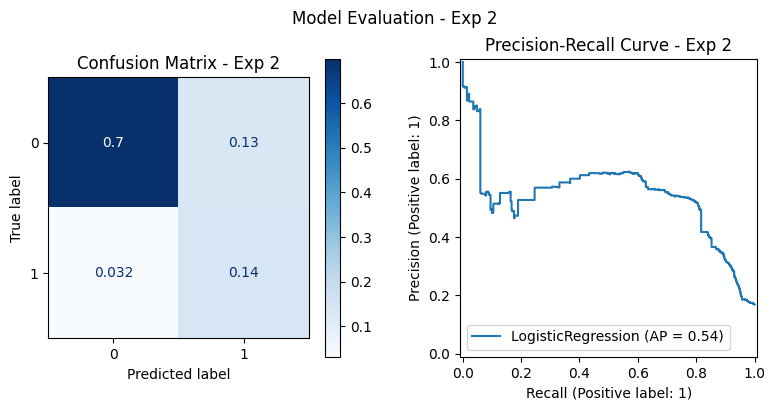

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test, normalize='all', cmap='Blues', ax=ax1)
ax1.set_title("Confusion Matrix - Exp 2")

PrecisionRecallDisplay.from_estimator(lr, X_test, y_test, ax=ax2)
ax2.set_title("Precision-Recall Curve - Exp 2")

plt.suptitle("Model Evaluation - Exp 2")

plt.tight_layout()  # Ajusta para que no se solapen los títulos

plt.savefig("model_evaluation_exp2.png")
plt.show()

**Log model: Experiment 2**

In [16]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("Experiment 2")

# Start an MLflow run
with mlflow.start_run():
    # Log the dataset
    #mlflow.log_artifact(datasets.load_iris())

    # Log the hyperparameters
    mlflow.log_params(params)

    # Log metrics
    metrics = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "average_precision": average_precision,
        "accuracy": accuracy
    }

    mlflow.log_metrics(metrics)

    # Log plots
    mlflow.log_artifact("model_evaluation_exp2.png")

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Info", "Basic Logistic Regression Model on reservaciones_exp2")
    mlflow.set_tag("Model Type", "Logistic Regression")
    mlflow.set_tag("Dataset", "reservaciones_exp2.parquet")

    # Infer the model signature
    signature = infer_signature(X_train, lr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=lr,
        artifact_path="reservaciones_exp2_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="reservaciones_exp2_model"
    )

2025/06/08 15:04:34 INFO mlflow.tracking.fluent: Experiment with name 'Experiment 2' does not exist. Creating a new experiment.
Registered model 'reservaciones_exp2_model' already exists. Creating a new version of this model...
2025/06/08 15:04:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: reservaciones_exp2_model, version 6
Created version '6' of model 'reservaciones_exp2_model'.


🏃 View run nervous-shrike-491 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/36bcb72a7513454cb48b62d107322035
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


### Models training and hyperparameters tuning

In [17]:
np.random.seed(42)

#### Experiment 1

**Logistic Regression**

In [18]:
# Logistics regression params from parameters_data_science.yml
mlflow.set_experiment("Experiment 1")
run_name_prefix = f"RandomSearch_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

# Define the target variable and independent variables
X = df_exp1.drop('cancelacion', axis=1)
y = df_exp1['cancelacion']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Espacio de búsqueda válido agrupado por compatibilidad solver-penalty
param_dist = [
    {
        'solver': ['newton-cg', 'lbfgs', 'sag'],
        'penalty': ['l2', None],
        'C': [0.01, 0.1, 1, 5, 10],
        'class_weight': ['balanced', None],
        'max_iter': [100, 200, 300, 400, 500]
    },
    {
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1'],
        'C': [0.01, 0.1, 1, 5, 10],
        'class_weight': ['balanced', None],
        'max_iter': [100, 200, 300, 400, 500]
    },
    {
        'solver': ['saga'],
        'penalty': ['elasticnet'],
        'l1_ratio': [0.1, 0.5, 0.7, 0.9],
        'C': [0.01, 0.1, 1, 5, 10],
        'class_weight': ['balanced', None],
        'max_iter': [100, 200, 300, 400, 500]
    }
]

# Para RandomizedSearchCV, combinamos los espacios y muestreamos n_iter combinaciones
n_iter = 10
param_list = []
for param_group in param_dist:
    param_list.extend(list(ParameterSampler(param_group, n_iter=n_iter, random_state=42)))

# Limitamos a n_iter combinaciones totales
param_list = param_list[:n_iter]

best_score_lr = -np.inf
best_params_lr = None

for i, params in enumerate(param_list):
    with mlflow.start_run(run_name=f"{run_name_prefix}_run_{i+1}"):
        # Entrena el modelo con los parámetros actuales
        model = LogisticRegression(**params)
        model.fit(X_train, y_train)

        # Log metrics
        y_pred = model.predict(X_test)

        metrics = {
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred),
            "average_precision": average_precision_score(y_test, model.predict_proba(X_test)[:, 1])
        }

        mlflow.log_metrics(metrics)

        # Log parameters
        mlflow.log_params(params)

        # Log tags
        mlflow.set_tag("Model Type", "Logistic Regression")
        mlflow.set_tag("Run Type", "Hyperparameter Tuning")

        # Loguea el modelo con firma e input_example para trazabilidad
        from mlflow.models import infer_signature
        signature = infer_signature(X_train, model.predict(X_train))
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="model",
            signature=signature,
            input_example=X_train.head(5)
        )

        # Actualiza mejor resultado
        if recall > best_score_lr:
            best_score_lr = recall
            best_params_lr = params




c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


🏃 View run RandomSearch_20250608_150450_run_1 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/9a0553a07bd743f79db7506448002414
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


🏃 View run RandomSearch_20250608_150450_run_2 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/8242b2daaf4a4f02b6ee38b2c840ad69
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


🏃 View run RandomSearch_20250608_150450_run_3 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/4fc44fd25be64d52b3f8ef1d9a9dc009
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


🏃 View run RandomSearch_20250608_150450_run_4 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/a9ff77f1e6b745b294fff45a4e3693b5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


🏃 View run RandomSearch_20250608_150450_run_5 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/808b409cbc484b0ca83cb63bb2259c46
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


🏃 View run RandomSearch_20250608_150450_run_6 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/cf00241316504c0b95a035bfb382b960
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


🏃 View run RandomSearch_20250608_150450_run_7 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/61de19365b0d4969ad24506809c69476
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


🏃 View run RandomSearch_20250608_150450_run_8 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/ce4432e57da74323ab9a3223a0bd6fc6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


🏃 View run RandomSearch_20250608_150450_run_9 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/2c8c3aeb4f514c2e90055a9e436b3d3e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


🏃 View run RandomSearch_20250608_150450_run_10 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/d494ae9bbdbc413eb42f75b3f06a5bc9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


In [19]:
print("Mejores parámetros:", best_params_lr)  # noqa: T201
print("Mejor recall:", best_score_lr) # noqa: T201

Mejores parámetros: {'solver': 'sag', 'penalty': None, 'max_iter': 400, 'class_weight': 'balanced', 'C': 5}
Mejor recall: 0.8096085409252669


**Random Forest**

In [21]:
mlflow.set_experiment("Experiment 1")
run_name_prefix = f"RandomSearch_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

# Define features and target
X = df_exp1.drop('cancelacion', axis=1)
y = df_exp1['cancelacion']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Espacio de búsqueda para Random Forest
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

n_iter = 10
param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

best_score_rf = -np.inf
best_params_rf = None

for i, params in enumerate(param_list):
    with mlflow.start_run(run_name=f"{run_name_prefix}_run_{i+1}"):
        # Entrena el modelo con los parámetros actuales
        model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)

        # Predicciones y cálculo de métricas
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        metrics = {
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred),
            "average_precision": average_precision_score(y_test, y_proba)
        }

        # Loguea métricas y parámetros
        mlflow.log_metrics(metrics)
        mlflow.log_params(params)

        # Log tags
        mlflow.set_tag("Model Type", "Random Forest")
        mlflow.set_tag("Run Type", "Hyperparameter Tuning")

        # Loguea el modelo con firma e input_example para trazabilidad
        from mlflow.models import infer_signature
        signature = infer_signature(X_train, model.predict(X_train))
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="model",
            signature=signature,
            input_example=X_train.head(5)
        )

        # Actualiza mejor resultado basado en recall
        if metrics["recall"] > best_score_rf:
            best_score_rf = metrics["recall"]
            best_params_rf = params


🏃 View run RandomSearch_20250608_152147_run_1 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/93c0e7b7e2b44344b9d5b1953d8f98e4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


🏃 View run RandomSearch_20250608_152147_run_2 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/bac273ca4d944d55922c40fd06353022
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


🏃 View run RandomSearch_20250608_152147_run_3 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/b5a66070e7164e1a95d6b08c9dbb6d52
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


🏃 View run RandomSearch_20250608_152147_run_4 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/f13d1afa19924b0bb6b9322e16fa661f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


🏃 View run RandomSearch_20250608_152147_run_5 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/df51079041a0410abaea6c09ee911951
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


🏃 View run RandomSearch_20250608_152147_run_6 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/a34b37e3a7f1449c9f691c44629493ef
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


🏃 View run RandomSearch_20250608_152147_run_7 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/8936c889ed184b17836a6aa3b3c739de
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


🏃 View run RandomSearch_20250608_152147_run_8 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/9f01da24fee2460c998c041b2db6d6b6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


🏃 View run RandomSearch_20250608_152147_run_9 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/461045b84b0445c19c3b94cdf959bb3e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


🏃 View run RandomSearch_20250608_152147_run_10 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/b07aeee4e8a34eb389788285376cd7c5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


In [22]:
print("Mejores parámetros:", best_params_rf) # noqa: T201
print("Mejor recall:", best_score_rf) # noqa: T201

Mejores parámetros: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_leaf_nodes': 30, 'max_features': 'log2', 'max_depth': 40, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'bootstrap': False}
Mejor recall: 0.8570346812055126


**XGBoos**

In [23]:
mlflow.set_experiment("Experiment 1")
run_name_prefix = f"RandomSearch_XGB_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

# Define features and target
X = df_exp1.drop('cancelacion', axis=1)
y = df_exp1['cancelacion']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Espacio de búsqueda típico para XGBClassifier
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2],
    'scale_pos_weight': [1, 3, 5],  # útil para clases desbalanceadas
    'objective': ['binary:logistic'],
    'use_label_encoder': [False],
    'eval_metric': ['logloss']  # para evitar warning en XGBoost >1.3
}

n_iter = 10
param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

best_score_xgb = -np.inf
best_params_xgb = None

for i, params in enumerate(param_list):
    with mlflow.start_run(run_name=f"{run_name_prefix}_run_{i+1}"):
        # Crea el modelo con los parámetros actuales
        model = XGBClassifier(**params, random_state=42, verbosity=0)
        model.fit(X_train, y_train)

        # Predicciones y métricas
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        metrics = {
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred),
            "average_precision": average_precision_score(y_test, y_proba)
        }

        # Loguea métricas y parámetros
        mlflow.log_metrics(metrics)
        mlflow.log_params(params)

        # Log tags
        mlflow.set_tag("Model Type", "XGBoost Classifier")
        mlflow.set_tag("Run Type", "Hyperparameter Tuning")

        # Loguea el modelo con firma e input_example para trazabilidad
        from mlflow.models import infer_signature
        signature = infer_signature(X_train, model.predict(X_train))
        mlflow.xgboost.log_model(
            xgb_model=model,
            artifact_path="model",
            signature=signature,
            input_example=X_train.head(5)
        )

        # Actualiza mejor resultado basado en recall
        if metrics["recall"] > best_score_xgb:
            best_score_xgb = metrics["recall"]
            best_params_xgb = params


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:29:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


🏃 View run RandomSearch_XGB_20250608_152934_run_1 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/d091e9cf86e141a4b8f2f7050a502766
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:29:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


🏃 View run RandomSearch_XGB_20250608_152934_run_2 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/9c0c509a79a94a569304a3fe32796e75
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:30:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


🏃 View run RandomSearch_XGB_20250608_152934_run_3 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/4a99813e12c04bf6a96e150a8a3c30ee
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:30:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


🏃 View run RandomSearch_XGB_20250608_152934_run_4 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/d782ceec392140c49723d2401c90873f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:30:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


🏃 View run RandomSearch_XGB_20250608_152934_run_5 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/4e63246b99664808aa89cccb34ab509c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:31:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


🏃 View run RandomSearch_XGB_20250608_152934_run_6 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/c01d9f9358fd45d2b301aa6819b89c69
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:31:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


🏃 View run RandomSearch_XGB_20250608_152934_run_7 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/b9214a07de094d98a53200181d195c45
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:31:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


🏃 View run RandomSearch_XGB_20250608_152934_run_8 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/4a6b2dd0664f44629d53b3dd7782e7a6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:31:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


🏃 View run RandomSearch_XGB_20250608_152934_run_9 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/fc32d2ba391b4b0394693e67a73fc61c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:32:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


🏃 View run RandomSearch_XGB_20250608_152934_run_10 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/fdfe451caf624b68bc2fc8ce92c0c75f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


In [24]:
print("Mejores parámetros:", best_params_xgb) # noqa: T201
print("Mejor recall:", best_score_xgb) # noqa: T201

Mejores parámetros: {'use_label_encoder': False, 'subsample': 0.8, 'scale_pos_weight': 5, 'reg_lambda': 2, 'reg_alpha': 0, 'objective': 'binary:logistic', 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.3, 'eval_metric': 'logloss', 'colsample_bytree': 0.6}
Mejor recall: 0.8953505982129335


**KNN Classifier**

In [35]:
mlflow.set_experiment("Experiment 1")
run_name_prefix = f"RandomSearch_KNN_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

# Define features and target
X = df_exp1.drop('cancelacion', axis=1)
y = df_exp1['cancelacion']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Espacio de búsqueda típico para KNN
param_dist = {
    'n_neighbors': list(range(1, 31)),          # Número de vecinos
    'weights': ['uniform', 'distance'],         # Ponderación de los vecinos
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algoritmo para búsqueda
    'p': [1, 2]                                 # Parámetro para la distancia (1=Manhattan, 2=Euclidiana)
}

n_iter = 10
param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

best_score_knn = -np.inf
best_params_knn = None

for i, params in enumerate(param_list):
    with mlflow.start_run(run_name=f"{run_name_prefix}_run_{i+1}"):
        model = KNeighborsClassifier(**params)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        # KNN no tiene método predict_proba para algunos casos, así que evitamos average_precision si no está disponible
        try:
            y_proba = model.predict_proba(X_test)[:, 1]
            avg_prec = average_precision_score(y_test, y_proba)
        except AttributeError:
            avg_prec = None

        metrics = {
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred),
        }
        if avg_prec is not None:
            metrics["average_precision"] = avg_prec

        mlflow.log_metrics(metrics)
        mlflow.log_params(params)

        mlflow.set_tag("Model Type", "KNeighborsClassifier")
        mlflow.set_tag("Run Type", "Hyperparameter Tuning")

        from mlflow.models import infer_signature
        signature = infer_signature(X_train, model.predict(X_train))
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="model",
            signature=signature,
            input_example=X_train.head(5)
        )

        if metrics["recall"] > best_score_knn:
            best_score_knn = metrics["recall"]
            best_params_knn = params


🏃 View run RandomSearch_KNN_20250608_155746_run_1 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/5a681ec9033d4965bd30e0b3dfc56e83
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


🏃 View run RandomSearch_KNN_20250608_155746_run_2 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/98ec5077f3eb4ec7aed91e6ac3b2fdfd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


🏃 View run RandomSearch_KNN_20250608_155746_run_3 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/d7798d1a05eb43259201eb52ff38e551
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


🏃 View run RandomSearch_KNN_20250608_155746_run_4 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/83457d28550541ae8d0833965d11117a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


🏃 View run RandomSearch_KNN_20250608_155746_run_5 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/031e8960592647f8977759beb82f97a5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


🏃 View run RandomSearch_KNN_20250608_155746_run_6 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/d7db7e2db7f849bab165973fe6981598
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


🏃 View run RandomSearch_KNN_20250608_155746_run_7 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/b0b3b644f4dc4a19adccf3bcd1b2ba00
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


🏃 View run RandomSearch_KNN_20250608_155746_run_8 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/64438ae8fa7d4d3884f9a5f8894f4318
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


🏃 View run RandomSearch_KNN_20250608_155746_run_9 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/525180b961094a01a8833cecdbccf5a2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


🏃 View run RandomSearch_KNN_20250608_155746_run_10 at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/678dca812d0a46859ebb30e797069806
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


In [36]:
print("Mejores parámetros:", best_params_knn) # noqa: T201
print("Mejor recall:", best_score_knn) # noqa: T201


Mejores parámetros: {'weights': 'distance', 'p': 1, 'n_neighbors': 10, 'algorithm': 'kd_tree'}
Mejor recall: 0.7513251552324701


#### Experiment 2

**Logistic Regression**

In [27]:
mlflow.set_experiment("Experiment 2")
run_name_prefix = f"RandomSearch_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

# Define the target variable and independent variables
X = df_exp2.drop('cancelacion', axis=1)
y = df_exp2['cancelacion']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Espacio de búsqueda válido agrupado por compatibilidad solver-penalty
param_dist = [
    {
        'solver': ['newton-cg', 'lbfgs', 'sag'],
        'penalty': ['l2', None],
        'C': [0.01, 0.1, 1, 5, 10],
        'class_weight': ['balanced', None],
        'max_iter': [100, 200, 300, 400, 500]
    },
    {
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1'],
        'C': [0.01, 0.1, 1, 5, 10],
        'class_weight': ['balanced', None],
        'max_iter': [100, 200, 300, 400, 500]
    },
    {
        'solver': ['saga'],
        'penalty': ['elasticnet'],
        'l1_ratio': [0.1, 0.5, 0.7, 0.9],
        'C': [0.01, 0.1, 1, 5, 10],
        'class_weight': ['balanced', None],
        'max_iter': [100, 200, 300, 400, 500]
    }
]

# Para RandomizedSearchCV, combinamos los espacios y muestreamos n_iter combinaciones
n_iter = 10
param_list = []
for param_group in param_dist:
    param_list.extend(list(ParameterSampler(param_group, n_iter=n_iter, random_state=42)))

# Limitamos a n_iter combinaciones totales
param_list = param_list[:n_iter]

best_score_lr = -np.inf
best_params_lr = None

for i, params in enumerate(param_list):
    with mlflow.start_run(run_name=f"{run_name_prefix}_run_{i+1}"):
        # Entrena el modelo con los parámetros actuales
        model = LogisticRegression(**params)
        model.fit(X_train, y_train)

        # Log metrics
        y_pred = model.predict(X_test)

        metrics = {
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred),
            "average_precision": average_precision_score(y_test, model.predict_proba(X_test)[:, 1])
        }

        mlflow.log_metrics(metrics)

        # Log parameters
        mlflow.log_params(params)

        # Log tags
        mlflow.set_tag("Model Type", "Logistic Regression")
        mlflow.set_tag("Run Type", "Hyperparameter Tuning")

        # Loguea el modelo con firma e input_example para trazabilidad
        from mlflow.models import infer_signature
        signature = infer_signature(X_train, model.predict(X_train))
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="model",
            signature=signature,
            input_example=X_train.head(5)
        )

        # Actualiza mejor resultado
        if recall > best_score_lr:
            best_score_lr = recall
            best_params_lr = params




c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


🏃 View run RandomSearch_20250608_153841_run_1 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/1ebed90e14cd46709c1d7b5d2d310729
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


🏃 View run RandomSearch_20250608_153841_run_2 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/b0ec4ee4da1c4f53a86b8d37e47ffb31
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


🏃 View run RandomSearch_20250608_153841_run_3 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/2848c873efa34a1e9e4677e97e4b4963
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


🏃 View run RandomSearch_20250608_153841_run_4 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/254bee5da49e48389876a6a78aaaf55c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


🏃 View run RandomSearch_20250608_153841_run_5 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/5ea40d60db1b42a6bfb2f6a3c409796d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


🏃 View run RandomSearch_20250608_153841_run_6 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/4f71557d6c684f3db5e6666bd3fc3355
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


🏃 View run RandomSearch_20250608_153841_run_7 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/ca3cc005d6de4e9da2b602c05f96ca57
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


🏃 View run RandomSearch_20250608_153841_run_8 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/1e6da4640172496dbb11878e0e5dd9fe
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


🏃 View run RandomSearch_20250608_153841_run_9 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/ca31e069c1f04968afe2b5fd3bb2be50
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


🏃 View run RandomSearch_20250608_153841_run_10 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/1a8068d1e8c34bf0b2d2bbd9b5a21bce
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


In [28]:
print("Mejores parámetros:", best_params_lr)  # noqa: T201
print("Mejor recall:", best_score_lr) # noqa: T201

Mejores parámetros: {'solver': 'sag', 'penalty': None, 'max_iter': 400, 'class_weight': 'balanced', 'C': 5}
Mejor recall: 0.8096085409252669


**Random Forest**

In [29]:
mlflow.set_experiment("Experiment 2")
run_name_prefix = f"RandomSearch_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

# Define features and target
X = df_exp2.drop('cancelacion', axis=1)
y = df_exp2['cancelacion']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Espacio de búsqueda para Random Forest
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

n_iter = 10
param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

best_score_rf = -np.inf
best_params_rf = None

for i, params in enumerate(param_list):
    with mlflow.start_run(run_name=f"{run_name_prefix}_run_{i+1}"):
        # Entrena el modelo con los parámetros actuales
        model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)

        # Predicciones y cálculo de métricas
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        metrics = {
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred),
            "average_precision": average_precision_score(y_test, y_proba)
        }

        # Loguea métricas y parámetros
        mlflow.log_metrics(metrics)
        mlflow.log_params(params)

        # Log tags
        mlflow.set_tag("Model Type", "Random Forest")
        mlflow.set_tag("Run Type", "Hyperparameter Tuning")

        # Loguea el modelo con firma e input_example para trazabilidad
        from mlflow.models import infer_signature
        signature = infer_signature(X_train, model.predict(X_train))
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="model",
            signature=signature,
            input_example=X_train.head(5)
        )

        # Actualiza mejor resultado basado en recall
        if metrics["recall"] > best_score_rf:
            best_score_rf = metrics["recall"]
            best_params_rf = params


🏃 View run RandomSearch_20250608_154058_run_1 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/fc3b9ae62e2741f5b01ae32e029bca16
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


🏃 View run RandomSearch_20250608_154058_run_2 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/ea79f9a8d7ed4e16adc0161988778570
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


🏃 View run RandomSearch_20250608_154058_run_3 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/1d656e4ef94d46b4ba9fe1b5960cd563
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


🏃 View run RandomSearch_20250608_154058_run_4 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/ceefc46d20b4472cbe82ca57ed5d5de1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


🏃 View run RandomSearch_20250608_154058_run_5 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/1aed3756f776439ba5d23799e2a1a22b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


🏃 View run RandomSearch_20250608_154058_run_6 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/a5a0e4309afb4e16914a319af490e9aa
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


🏃 View run RandomSearch_20250608_154058_run_7 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/cdaa6687fc884a158408a5ea3f28ce05
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


🏃 View run RandomSearch_20250608_154058_run_8 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/fab5206cceab44e99a2778b804ff1686
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


🏃 View run RandomSearch_20250608_154058_run_9 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/18be839862b942ce83a54d97d827a300
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


🏃 View run RandomSearch_20250608_154058_run_10 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/28d092c1e5414dffbebbb8693d07e05d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


In [30]:
print("Mejores parámetros:", best_params_rf) # noqa: T201
print("Mejor recall:", best_score_rf) # noqa: T201

Mejores parámetros: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 40, 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': False}
Mejor recall: 0.8959074733096085


**XGBoos**

In [31]:
mlflow.set_experiment("Experiment 2")
run_name_prefix = f"RandomSearch_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

# Define the target variable and independent variables
X = df_exp2.drop('cancelacion', axis=1)
y = df_exp2['cancelacion']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Espacio de búsqueda típico para XGBClassifier
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2],
    'scale_pos_weight': [1, 3, 5],  # útil para clases desbalanceadas
    'objective': ['binary:logistic'],
    'use_label_encoder': [False],
    'eval_metric': ['logloss']  # para evitar warning en XGBoost >1.3
}

n_iter = 10
param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

best_score_xgb = -np.inf
best_params_xgb = None

for i, params in enumerate(param_list):
    with mlflow.start_run(run_name=f"{run_name_prefix}_run_{i+1}"):
        # Crea el modelo con los parámetros actuales
        model = XGBClassifier(**params, random_state=42, verbosity=0)
        model.fit(X_train, y_train)

        # Predicciones y métricas
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        metrics = {
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred),
            "average_precision": average_precision_score(y_test, y_proba)
        }

        # Loguea métricas y parámetros
        mlflow.log_metrics(metrics)
        mlflow.log_params(params)

        # Log tags
        mlflow.set_tag("Model Type", "XGBoost Classifier")
        mlflow.set_tag("Run Type", "Hyperparameter Tuning")

        # Loguea el modelo con firma e input_example para trazabilidad
        from mlflow.models import infer_signature
        signature = infer_signature(X_train, model.predict(X_train))
        mlflow.xgboost.log_model(
            xgb_model=model,
            artifact_path="model",
            signature=signature,
            input_example=X_train.head(5)
        )

        # Actualiza mejor resultado basado en recall
        if metrics["recall"] > best_score_xgb:
            best_score_xgb = metrics["recall"]
            best_params_xgb = params


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:43:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


🏃 View run RandomSearch_20250608_154349_run_1 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/81943b0c73eb40f9af27bfab65a2aefc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:44:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


🏃 View run RandomSearch_20250608_154349_run_2 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/1ad0e0bbb0964b4faf0854db7524cc7d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:44:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


🏃 View run RandomSearch_20250608_154349_run_3 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/2c0346281aae4952a43b939ec3e2084c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:44:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


🏃 View run RandomSearch_20250608_154349_run_4 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/1423b7b8956d4aff90a9381f5a5c7181
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:44:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


🏃 View run RandomSearch_20250608_154349_run_5 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/d3d00b6c9ce14cdf87996d330237f41f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:45:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


🏃 View run RandomSearch_20250608_154349_run_6 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/0a6bd83ae61949f18568649c23bf54ee
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:45:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


🏃 View run RandomSearch_20250608_154349_run_7 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/01684ecdaf7f4718bc1a48697adc1a4a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:45:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


🏃 View run RandomSearch_20250608_154349_run_8 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/b477d2b367834a998ac62ed2ac57c2c3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:45:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


🏃 View run RandomSearch_20250608_154349_run_9 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/f293e1704a124734a841674bf2255fe6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:45:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


🏃 View run RandomSearch_20250608_154349_run_10 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/8c0a00cf82c046e2b9c877d448193e16
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


In [32]:
print("Mejores parámetros:", best_params_xgb) # noqa: T201
print("Mejor recall:", best_score_xgb) # noqa: T201

Mejores parámetros: {'use_label_encoder': False, 'subsample': 0.8, 'scale_pos_weight': 5, 'reg_lambda': 1, 'reg_alpha': 0, 'objective': 'binary:logistic', 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.5, 'eval_metric': 'logloss', 'colsample_bytree': 0.8}
Mejor recall: 0.8806346381969158


**KNN Classifier**

In [33]:
mlflow.set_experiment("Experiment 2")
run_name_prefix = f"RandomSearch_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

# Define the target variable and independent variables
X = df_exp2.drop('cancelacion', axis=1)
y = df_exp2['cancelacion']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Espacio de búsqueda típico para KNN
param_dist = {
    'n_neighbors': list(range(1, 31)),          # Número de vecinos
    'weights': ['uniform', 'distance'],         # Ponderación de los vecinos
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algoritmo para búsqueda
    'p': [1, 2]                                 # Parámetro para la distancia (1=Manhattan, 2=Euclidiana)
}

n_iter = 10
param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

best_score_knn = -np.inf
best_params_knn = None

for i, params in enumerate(param_list):
    with mlflow.start_run(run_name=f"{run_name_prefix}_run_{i+1}"):
        model = KNeighborsClassifier(**params)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        # KNN no tiene método predict_proba para algunos casos, así que evitamos average_precision si no está disponible
        try:
            y_proba = model.predict_proba(X_test)[:, 1]
            avg_prec = average_precision_score(y_test, y_proba)
        except AttributeError:
            avg_prec = None

        metrics = {
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred),
        }
        if avg_prec is not None:
            metrics["average_precision"] = avg_prec

        mlflow.log_metrics(metrics)
        mlflow.log_params(params)

        mlflow.set_tag("Model Type", "KNeighborsClassifier")
        mlflow.set_tag("Run Type", "Hyperparameter Tuning")

        from mlflow.models import infer_signature
        signature = infer_signature(X_train, model.predict(X_train))
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="model",
            signature=signature,
            input_example=X_train.head(5)
        )

        if metrics["recall"] > best_score_knn:
            best_score_knn = metrics["recall"]
            best_params_knn = params


🏃 View run RandomSearch_20250608_154608_run_1 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/09022abacf7549b18498bc1dab75f2ba
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


🏃 View run RandomSearch_20250608_154608_run_2 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/3478c62a90404be78d6091d8f00bf373
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


🏃 View run RandomSearch_20250608_154608_run_3 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/4b694d56d4cc4221be23b1195f41d342
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


🏃 View run RandomSearch_20250608_154608_run_4 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/eede72d648304cdc8a0e31476a10e364
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


🏃 View run RandomSearch_20250608_154608_run_5 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/de902d64d4d64865aad0fc5e4e311bb2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


🏃 View run RandomSearch_20250608_154608_run_6 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/27cc00a0520749bf95cae6fefae8a15e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


🏃 View run RandomSearch_20250608_154608_run_7 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/95215460c5514ae6ae660423f687d102
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


🏃 View run RandomSearch_20250608_154608_run_8 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/ac1960365a06426f8ee6d99bf9156028
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


🏃 View run RandomSearch_20250608_154608_run_9 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/219f6c17e6654245b68bc36cd288d316
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


🏃 View run RandomSearch_20250608_154608_run_10 at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/2360e3d81e8941f982cd0379cf22d786
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


In [34]:
print("Mejores parámetros:", best_params_knn) # noqa: T201
print("Mejor recall:", best_score_knn) # noqa: T201

Mejores parámetros: {'weights': 'distance', 'p': 1, 'n_neighbors': 19, 'algorithm': 'auto'}
Mejor recall: 0.7239027283511269


---
---

### Best Models: Training and deployment in MLflow

**Experiment 1:** Random Forest

In [ ]:
mlflow.set_experiment("Experiment 1")
run_name_prefix = "Best_Model_Exp1_RandomForest"

# Define the target variable and independent variables
X = df_exp1.drop('cancelacion', axis=1)
y = df_exp1['cancelacion']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Best parameters from previous runs
best_params_rf = {
    "bootstrap": True,
    "class_weight": "balanced_subsample",
    "max_depth": 20,
    "max_features": "log2",
    "min_samples_leaf": 4,
    "min_samples_split": 10,
    "n_estimators": 50}

# Train the best Random Forest model
rf = RandomForestClassifier(**best_params_rf, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)


In [8]:
# Evaluation
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['No Cancellation', 'Cancellation']))  # noqa: T201

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
y_scores = rf.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(y_test, y_scores)
accuracy = accuracy_score(y_test, y_pred)

                 precision    recall  f1-score   support

No Cancellation       0.98      0.86      0.92     33896
   Cancellation       0.56      0.91      0.70      6603

       accuracy                           0.87     40499
      macro avg       0.77      0.89      0.81     40499
   weighted avg       0.91      0.87      0.88     40499



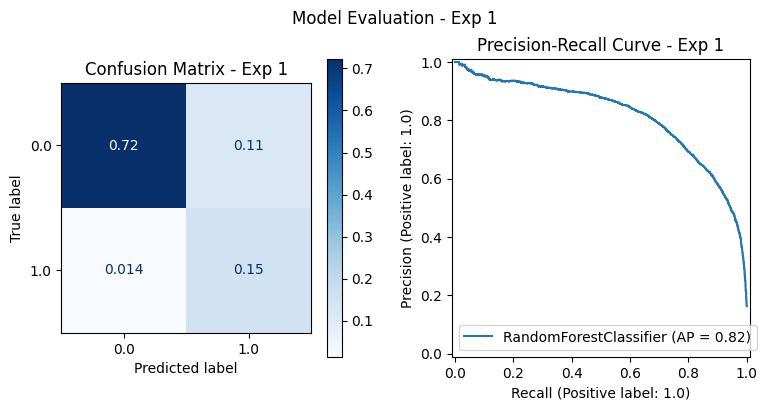

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, normalize='all', cmap='Blues', ax=ax1)
ax1.set_title("Confusion Matrix - Exp 1")

PrecisionRecallDisplay.from_estimator(rf, X_test, y_test, ax=ax2)
ax2.set_title("Precision-Recall Curve - Exp 1")

plt.suptitle("Model Evaluation - Exp 1")

plt.tight_layout()  # Ajusta para que no se solapen los títulos

plt.savefig("model_evaluation_exp1.png")
plt.show()

In [14]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("Experiment 1")

# Start an MLflow run
with mlflow.start_run(run_name=run_name_prefix):
    # Log the dataset
    #mlflow.log_artifact(datasets.load_iris())

    # Log the hyperparameters
    mlflow.log_params(best_params_rf)

    # Log metrics
    metrics = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "average_precision": average_precision,
        "accuracy": accuracy
    }

    mlflow.log_metrics(metrics)

    # Log plots
    mlflow.log_artifact("model_evaluation_exp1.png")

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Info", "Best model Exp 1")
    mlflow.set_tag("Model Type", "Random Forest")
    mlflow.set_tag("Dataset", "reservaciones_exp1.parquet")

    # Infer the model signature
    signature = infer_signature(X_train, rf.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=rf,
        artifact_path="reservaciones_exp1_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="RandomForest_BM_Exp1"
    )

Registered model 'RandomForest_BM_Exp1' already exists. Creating a new version of this model...
2025/06/13 22:00:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForest_BM_Exp1, version 2


🏃 View run Best_Model_Exp1_RandomForest at: http://127.0.0.1:5000/#/experiments/225744905131217093/runs/1297b2ca3f034f4f87d455ebb6f01099
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/225744905131217093


Created version '2' of model 'RandomForest_BM_Exp1'.


**Experiment 2:** Random Forest

In [ ]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("Experiment 2")
run_name_prefix = "Best_Model_Exp2_RandomForest"

# Define the target variable and independent variables
X = df_exp2.drop('cancelacion', axis=1)
y = df_exp2['cancelacion']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Best parameters from previous runs
best_params_rf = {
    "bootstrap": False,
    "class_weight": "balanced",
    "criterion": "entropy",
    "max_depth": 40,
    "max_features": None,
    "max_leaf_nodes": None,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "n_estimators": 200}

# Train the best Random Forest model
rf = RandomForestClassifier(**best_params_rf, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=40, max_features=None,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [16]:
# Evaluation
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['No Cancellation', 'Cancellation']))  # noqa: T201

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
y_scores = rf.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(y_test, y_scores)
accuracy = accuracy_score(y_test, y_pred)

                 precision    recall  f1-score   support

No Cancellation       0.98      0.89      0.93     33219
   Cancellation       0.62      0.90      0.74      6744

       accuracy                           0.89     39963
      macro avg       0.80      0.89      0.83     39963
   weighted avg       0.92      0.89      0.90     39963



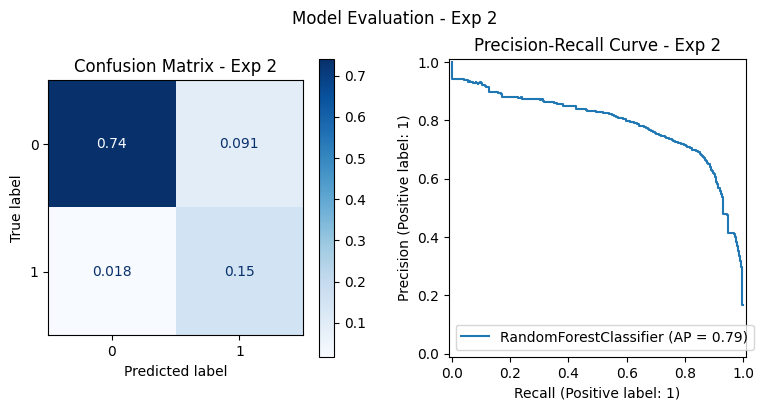

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, normalize='all', cmap='Blues', ax=ax1)
ax1.set_title("Confusion Matrix - Exp 2")

PrecisionRecallDisplay.from_estimator(rf, X_test, y_test, ax=ax2)
ax2.set_title("Precision-Recall Curve - Exp 2")

plt.suptitle("Model Evaluation - Exp 2")

plt.tight_layout()  # Ajusta para que no se solapen los títulos

plt.savefig("model_evaluation_exp2.png")
plt.show()

In [18]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("Experiment 2")

# Start an MLflow run
with mlflow.start_run(run_name=run_name_prefix):
    # Log the dataset
    #mlflow.log_artifact(datasets.load_iris())

    # Log the hyperparameters
    mlflow.log_params(best_params_rf)

    # Log metrics
    metrics = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "average_precision": average_precision,
        "accuracy": accuracy
    }

    mlflow.log_metrics(metrics)

    # Log plots
    mlflow.log_artifact("model_evaluation_exp1.png")

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Info", "Best model Exp 2")
    mlflow.set_tag("Model Type", "Random Forest")
    mlflow.set_tag("Dataset", "reservaciones_exp2.parquet")

    # Infer the model signature
    signature = infer_signature(X_train, rf.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=rf,
        artifact_path="reservaciones_exp2_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="RandomForest_BM_Exp2"
    )

Successfully registered model 'RandomForest_BM_Exp2'.
2025/06/13 22:05:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForest_BM_Exp2, version 1


🏃 View run Best_Model_Exp2_RandomForest at: http://127.0.0.1:5000/#/experiments/723662218742010694/runs/94b529e3782b4fdfa8b75ff1b733eac1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/723662218742010694


Created version '1' of model 'RandomForest_BM_Exp2'.


---
---

### Train a Neural Network

**Experimento 1**

In [34]:
import mlflow.tensorflow
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
# 1. Preprocesamiento de datos
# Suponiendo un DataFrame 'df' con características y columna 'is_canceled'
X = df_exp1.drop('cancelacion', axis=1)
y = df_exp1['cancelacion']

# Normalización y split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y)

# 2. Arquitectura de la red
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# 3. Compilación con parámetros optimizados
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.AUC(name='pr_auc', curve='PR')
                       ])

# 4. Entrenamiento con early stopping (edtener luego de no mejorar durante 5 épocas)
early_stop = EarlyStopping(
                            monitor='val_loss',
                            min_delta=0.001,
                            patience=5,
                            verbose=1,
                            mode='min',
                            restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=256,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    class_weight={0:1, 1:3})  # Ajuste para clases desbalanceadas

# 5. Evaluación del modelo
loss, accuracy, recall, precision, average_precision = model.evaluate(X_test, y_test)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Average Precision: {average_precision:.4f}")  # noqa: T201


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7942 - loss: 0.7126 - pr_auc: 0.4294 - precision: 0.4098 - recall: 0.5222 - val_accuracy: 0.8427 - val_loss: 0.3609 - val_pr_auc: 0.5801 - val_precision: 0.5216 - val_recall: 0.6950
Epoch 2/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8328 - loss: 0.5955 - pr_auc: 0.5527 - precision: 0.4925 - recall: 0.6916 - val_accuracy: 0.8375 - val_loss: 0.3666 - val_pr_auc: 0.5868 - val_precision: 0.5094 - val_recall: 0.7096
Epoch 3/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8344 - loss: 0.5844 - pr_auc: 0.5705 - precision: 0.4967 - recall: 0.6890 - val_accuracy: 0.8418 - val_loss: 0.3566 - val_pr_auc: 0.6010 - val_precision: 0.5191 - val_recall: 0.7087
Epoch 4/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8343 - loss: 0.5820 - pr_auc: 0.5726 - precision: 0.4953 - recall: 0.7021 - val_accuracy: 0.8414 - val_loss: 0.3521 - val_pr_auc: 0.6042 - val_precision: 0.5184 - val_recall: 0.7037
Epoc

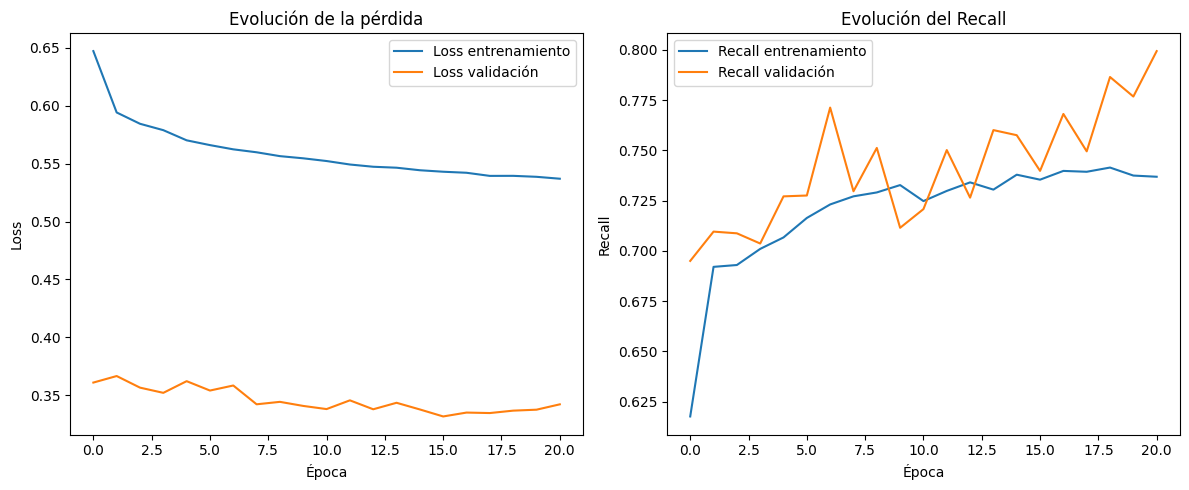

In [28]:
# Graficar pérdida (loss)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Loss entrenamiento')
plt.plot(history.history['val_loss'], label='Loss validación')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Evolución de la pérdida')
plt.legend()

# Graficar recall
plt.subplot(1,2,2)
plt.plot(history.history['recall'], label='Recall entrenamiento')
plt.plot(history.history['val_recall'], label='Recall validación')
plt.xlabel('Época')
plt.ylabel('Recall')
plt.title('Evolución del Recall')
plt.legend()

plt.tight_layout()
plt.show()


#### **Interpretación de las gráficas**
No de las últimas

1. **Pérdida (Loss)**
- **Entrenamiento:** La pérdida disminuye rápidamente al inicio y luego se estabiliza, lo cual es típico y esperado.
- **Validación:** La pérdida de validación es consistentemente menor que la de entrenamiento y se mantiene estable.
- **No hay señales claras de overfitting:** Normalmente, si la pérdida de validación sube mientras la de entrenamiento baja, hay sobreajuste. Aquí ambas se estabilizan y la de validación incluso es menor.

2. **Recall**
- **Entrenamiento:** El recall sube rápido y se estabiliza.
- **Validación:** El recall de validación muestra mucha variabilidad (ruido) pero oscila en torno al valor del entrenamiento.
- **Conclusión:** El modelo no está sobreajustando, pero el recall de validación es inestable, lo que puede indicar:
  - Dataset pequeño
  - Variabilidad en los datos de validación
  - Modelo sensible a pequeñas fluctuaciones

---

 **¿Cómo mejorar tu modelo?**

**1. Reduce la variabilidad del recall de validación**
- **Aumenta el tamaño del batch:** Usa batch_size=512 o 1024 si tu hardware lo permite. Esto suaviza las curvas de validación.
- **Haz k-fold cross-validation:** Así tendrás una mejor estimación de la performance real y menos variabilidad.
- **Aumenta el tamaño del dataset:** Si es posible, agrega más datos de entrenamiento.

**2. Ajusta la arquitectura**
- **Reduce la complejidad:** Prueba con menos neuronas o una sola capa oculta. Tu modelo podría estar ligeramente sobredimensionado para la cantidad de datos.
- **Aumenta la regularización:** Sube un poco el dropout (por ejemplo, 0.4 y 0.3) para ver si mejora la estabilidad.

**3. Ajusta el early stopping**
- **Aumenta `patience`:** Si el recall oscila mucho, prueba con `patience=10` para que el early stopping no corte demasiado pronto.
- **Monitorea otra métrica:** Puedes probar monitorear `val_recall` o `val_pr_auc` si te interesa más recall o precisión-recall.

**4. Ingenería de características**
- **Crea nuevas variables:** Por ejemplo, días hasta la reserva, tipo de cliente, época del año, etc.
- **Prueba con otras codificaciones:** Si tienes variables categóricas, prueba One-Hot Encoding o Embeddings si hay muchas categorías.

**5. Balanceo de clases**
- **Prueba diferentes `class_weight`:** Ajusta los pesos para ver si puedes mejorar recall sin perder precisión.

**6. Otras recomendaciones**
- **Evalúa otras métricas:** El PR AUC es muy útil en problemas desbalanceados. Si tienes un PR AUC alto, tu modelo está funcionando bien aunque el recall oscile.
- **Normaliza bien tus datos:** Ya lo haces, pero asegúrate que no haya outliers extremos.


**Resumen de pasos sugeridos**

1. **Aumenta el batch_size** para suavizar la curva de validación.
2. **Haz cross-validation** para una mejor estimación.
3. **Ajusta la arquitectura** y la regularización.
4. **Juega con los pesos de clase**.
5. **Prueba monitorear otras métricas** en el early stopping.
6. **Agrega más datos** o haz ingeniería de características.


In [31]:
# Evaluation
y_pred_proba = model.predict(X_test)  # Probabilidades
y_pred = (y_pred_proba >= 0.5).astype(int)  # Etiquetas binarias 0 o 1

print(classification_report(y_test, y_pred, target_names=['No Cancellation', 'Cancellation']))  # noqa: T201

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Average Precision: {average_precision:.4f}, Accuracy: {accuracy:.4f}")

1899/1899 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
                 precision    recall  f1-score   support

No Cancellation       0.94      0.86      0.90     50759
   Cancellation       0.51      0.74      0.61      9989

       accuracy                           0.84     60748
      macro avg       0.73      0.80      0.75     60748
   weighted avg       0.87      0.84      0.85     60748

Precision: 0.5139, Recall: 0.7412, F1: 0.6070, Average Precision: 0.6392, Accuracy: 0.8422


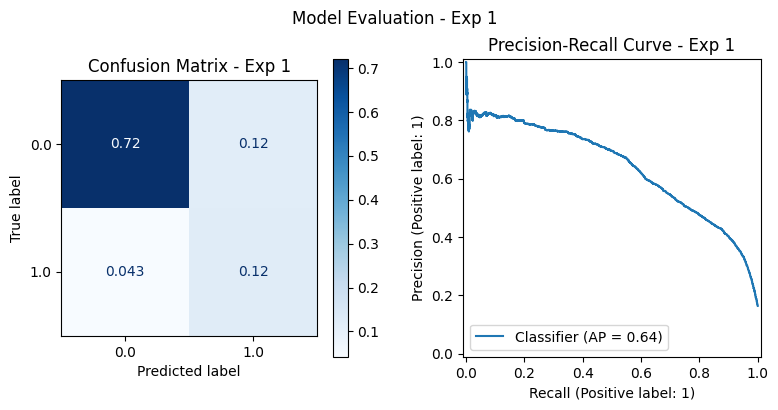

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Matriz de confusión normalizada
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    normalize='all',
    cmap='Blues',
    ax=ax1
)
ax1.set_title("Confusion Matrix - Exp 1")

# Curva Precision-Recall usando probabilidades
PrecisionRecallDisplay.from_predictions(
    y_test, y_pred_proba,
    ax=ax2
)
ax2.set_title("Precision-Recall Curve - Exp 1")

plt.suptitle("Model Evaluation - Exp 1")
plt.tight_layout()
plt.show()

**Registrar entreamientos en MLflow**

a) Autologging

In [35]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("Neural_Networks")

# Habilitar autologging antes de entrenar el modelo
mlflow.tensorflow.autolog()

# 1. Preprocesamiento de datos
X = df_exp1.drop('cancelacion', axis=1)
y = df_exp1['cancelacion']

# Normalización y split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y)

# 2. Arquitectura de la red
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# 3. Compilación con parámetros optimizados
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.AUC(name='pr_auc', curve='PR')
                       ])

# 4. Entrenamiento con early stopping (edtener luego de no mejorar durante 5 épocas)
early_stop = EarlyStopping(
                            monitor='val_loss',
                            min_delta=0.001,
                            patience=5,
                            verbose=1,
                            mode='min',
                            restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=256,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    class_weight={0:1, 1:3})  # Ajuste para clases desbalanceadas

# 5. Evaluación del modelo
loss, accuracy, recall, precision, average_precision = model.evaluate(X_test, y_test)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Average Precision: {average_precision:.4f}")  # noqa: T201



2025/06/14 12:55:54 INFO mlflow.tracking.fluent: Experiment with name 'Neural_Networks' does not exist. Creating a new experiment.
c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025/06/14 12:55:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9e2d8920b0b14f989b3087647b59d0e6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/06/14 12:55:55 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/100
441/443 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8045 - loss: 0.7078 - pr_auc: 0.4319 - precision: 0.4259 - recall: 0.5409

[14/06/2025 12:56:02 p. m.] WARNING  You are saving your model as an HDF5 file via `model.save()`  saving_api.py:83
                                     or `keras.saving.save_model(model)`. This file format is                      
                                     considered legacy. We recommend using instead the native                      
                                     Keras format, e.g. `model.save('my_model.keras')` or                          
                                     `keras.saving.save_model(model, 'my_model.keras')`.                           

443/443 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8046 - loss: 0.7074 - pr_auc: 0.4323 - precision: 0.4262 - recall: 0.5415 - val_accuracy: 0.8366 - val_loss: 0.3703 - val_pr_auc: 0.5699 - val_precision: 0.5069 - val_recall: 0.6782
Epoch 2/100
437/443 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8329 - loss: 0.5963 - pr_auc: 0.5489 - precision: 0.4947 - recall: 0.6819

[14/06/2025 12:56:05 p. m.] WARNING  You are saving your model as an HDF5 file via `model.save()`  saving_api.py:83
                                     or `keras.saving.save_model(model)`. This file format is                      
                                     considered legacy. We recommend using instead the native                      
                                     Keras format, e.g. `model.save('my_model.keras')` or                          
                                     `keras.saving.save_model(model, 'my_model.keras')`.                           

443/443 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8329 - loss: 0.5963 - pr_auc: 0.5489 - precision: 0.4947 - recall: 0.6820 - val_accuracy: 0.8398 - val_loss: 0.3630 - val_pr_auc: 0.5809 - val_precision: 0.5141 - val_recall: 0.6919
Epoch 3/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8332 - loss: 0.5842 - pr_auc: 0.5611 - precision: 0.4914 - recall: 0.6875 - val_accuracy: 0.8358 - val_loss: 0.3677 - val_pr_auc: 0.5892 - val_precision: 0.5048 - val_recall: 0.7095
Epoch 4/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8361 - loss: 0.5763 - pr_auc: 0.5714 - precision: 0.5014 - recall: 0.7007

[14/06/2025 12:56:11 p. m.] WARNING  You are saving your model as an HDF5 file via `model.save()`  saving_api.py:83
                                     or `keras.saving.save_model(model)`. This file format is                      
                                     considered legacy. We recommend using instead the native                      
                                     Keras format, e.g. `model.save('my_model.keras')` or                          
                                     `keras.saving.save_model(model, 'my_model.keras')`.                           

443/443 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8361 - loss: 0.5763 - pr_auc: 0.5714 - precision: 0.5014 - recall: 0.7006 - val_accuracy: 0.8358 - val_loss: 0.3610 - val_pr_auc: 0.5983 - val_precision: 0.5049 - val_recall: 0.7176
Epoch 5/100
436/443 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8347 - loss: 0.5706 - pr_auc: 0.5767 - precision: 0.4958 - recall: 0.7042

[14/06/2025 12:56:14 p. m.] WARNING  You are saving your model as an HDF5 file via `model.save()`  saving_api.py:83
                                     or `keras.saving.save_model(model)`. This file format is                      
                                     considered legacy. We recommend using instead the native                      
                                     Keras format, e.g. `model.save('my_model.keras')` or                          
                                     `keras.saving.save_model(model, 'my_model.keras')`.                           

443/443 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8347 - loss: 0.5705 - pr_auc: 0.5768 - precision: 0.4958 - recall: 0.7042 - val_accuracy: 0.8454 - val_loss: 0.3402 - val_pr_auc: 0.6081 - val_precision: 0.5274 - val_recall: 0.6888
Epoch 6/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8343 - loss: 0.5662 - pr_auc: 0.5805 - precision: 0.4955 - recall: 0.7125 - val_accuracy: 0.8389 - val_loss: 0.3532 - val_pr_auc: 0.6096 - val_precision: 0.5114 - val_recall: 0.7220
Epoch 7/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8361 - loss: 0.5575 - pr_auc: 0.6097 - precision: 0.5065 - recall: 0.7254 - val_accuracy: 0.8411 - val_loss: 0.3495 - val_pr_auc: 0.6180 - val_precision: 0.5164 - val_recall: 0.7136
Epoch 8/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8367 - loss: 0.5506 - pr_auc: 0.5989 - precision: 0.4996 - recall: 0.7212 - val_accuracy: 0.8403 - val_loss: 0.3464 - val_pr_auc: 0.6182 - val_precision: 0.5145 - val_recall: 0.7195
Epoch 9/100
443/

b) Logging manual

In [36]:
# Configura el tracking server y el experimento
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Neural_Networks")

# Diccionario con los parámetros del experimento
params = {
    "learning_rate": 0.001,
    "batch_size": 256,
    "epochs": 100,
    "dropout_1": 0.3,
    "dropout_2": 0.2,
    "class_weight_0": 1,
    "class_weight_1": 3,
    "test_size": 0.25
}

# Tags personalizados (puedes agregar más)
tags = {
    "model_type": "keras_sequential"
    }

# Nombre del run con fecha y hora
run_name = f"Neural_Network_{datetime.now().strftime('%Y%m%d_%H%M%S')}"


# 1. Preprocesamiento de datos
X = df_exp1.drop('cancelacion', axis=1)
y = df_exp1['cancelacion']

# Normalización y split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=params["test_size"], stratify=y)


with mlflow.start_run(run_name=run_name) as run:
    # Loguear todos los parámetros del diccionario
    mlflow.log_params(params)

    # Loguear tags
    mlflow.set_tags(tags)

    # Definir y compilar el modelo usando parámetros del diccionario
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(params["dropout_1"]),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(params["dropout_2"]),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=params["learning_rate"]),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.AUC(name='pr_auc', curve='PR')
        ]
    )

    # Entrenamiento con early stopping (puedes definirlo antes)
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.001,
        patience=5,
        verbose=1,
        mode='min',
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        validation_split=0.2,
        callbacks=[early_stop],
        class_weight={0: params["class_weight_0"], 1: params["class_weight_1"]}
    )

    # Loguear métricas finales (última época)
    mlflow.log_metric("final_val_loss", history.history['val_loss'][-1])
    mlflow.log_metric("final_val_accuracy", history.history['val_accuracy'][-1])
    mlflow.log_metric("final_val_recall", history.history['val_recall'][-1])
    mlflow.log_metric("final_val_precision", history.history['val_precision'][-1])
    mlflow.log_metric("final_val_pr_auc", history.history['val_pr_auc'][-1])

    # Inferir la firma del modelo (inputs y outputs) para documentación y validación
    signature = infer_signature(X_train, model.predict(X_train))

    # Loguear el modelo con la firma
    mlflow.tensorflow.log_model(model, artifact_path="model", signature=signature)

    # Opcional: setear el nombre del run también como tag (útil para UI)
    mlflow.set_tag("mlflow.runName", run_name)


c:\Users\Esteban\Documents\. Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025/06/14 13:16:13 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/100
466/475 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8115 - loss: 0.7016 - pr_auc: 0.4307 - precision: 0.4288 - recall: 0.5244

[14/06/2025 01:16:20 p. m.] WARNING  You are saving your model as an HDF5 file via `model.save()`  saving_api.py:83
                                     or `keras.saving.save_model(model)`. This file format is                      
                                     considered legacy. We recommend using instead the native                      
                                     Keras format, e.g. `model.save('my_model.keras')` or                          
                                     `keras.saving.save_model(model, 'my_model.keras')`.                           

475/475 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8117 - loss: 0.7004 - pr_auc: 0.4322 - precision: 0.4297 - recall: 0.5266 - val_accuracy: 0.8246 - val_loss: 0.3848 - val_pr_auc: 0.5546 - val_precision: 0.4731 - val_recall: 0.7194
Epoch 2/100
473/475 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8254 - loss: 0.6009 - pr_auc: 0.5394 - precision: 0.4777 - recall: 0.6856

[14/06/2025 01:16:23 p. m.] WARNING  You are saving your model as an HDF5 file via `model.save()`  saving_api.py:83
                                     or `keras.saving.save_model(model)`. This file format is                      
                                     considered legacy. We recommend using instead the native                      
                                     Keras format, e.g. `model.save('my_model.keras')` or                          
                                     `keras.saving.save_model(model, 'my_model.keras')`.                           

475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8254 - loss: 0.6009 - pr_auc: 0.5395 - precision: 0.4778 - recall: 0.6857 - val_accuracy: 0.8335 - val_loss: 0.3686 - val_pr_auc: 0.5674 - val_precision: 0.4909 - val_recall: 0.7089
Epoch 3/100
468/475 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8340 - loss: 0.5830 - pr_auc: 0.5766 - precision: 0.5004 - recall: 0.7036

[14/06/2025 01:16:26 p. m.] WARNING  You are saving your model as an HDF5 file via `model.save()`  saving_api.py:83
                                     or `keras.saving.save_model(model)`. This file format is                      
                                     considered legacy. We recommend using instead the native                      
                                     Keras format, e.g. `model.save('my_model.keras')` or                          
                                     `keras.saving.save_model(model, 'my_model.keras')`.                           

475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8340 - loss: 0.5830 - pr_auc: 0.5764 - precision: 0.5003 - recall: 0.7036 - val_accuracy: 0.8366 - val_loss: 0.3581 - val_pr_auc: 0.5787 - val_precision: 0.4973 - val_recall: 0.7095
Epoch 4/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8353 - loss: 0.5731 - pr_auc: 0.5849 - precision: 0.5021 - recall: 0.7143 - val_accuracy: 0.8312 - val_loss: 0.3638 - val_pr_auc: 0.5869 - val_precision: 0.4866 - val_recall: 0.7400
Epoch 5/100
467/475 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8342 - loss: 0.5711 - pr_auc: 0.5887 - precision: 0.4993 - recall: 0.7167

[14/06/2025 01:16:31 p. m.] WARNING  You are saving your model as an HDF5 file via `model.save()`  saving_api.py:83
                                     or `keras.saving.save_model(model)`. This file format is                      
                                     considered legacy. We recommend using instead the native                      
                                     Keras format, e.g. `model.save('my_model.keras')` or                          
                                     `keras.saving.save_model(model, 'my_model.keras')`.                           

475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8342 - loss: 0.5710 - pr_auc: 0.5887 - precision: 0.4992 - recall: 0.7168 - val_accuracy: 0.8366 - val_loss: 0.3507 - val_pr_auc: 0.5961 - val_precision: 0.4975 - val_recall: 0.7318
Epoch 6/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8301 - loss: 0.5647 - pr_auc: 0.5842 - precision: 0.4894 - recall: 0.7254 - val_accuracy: 0.8254 - val_loss: 0.3554 - val_pr_auc: 0.6040 - val_precision: 0.4761 - val_recall: 0.7625
Epoch 7/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8308 - loss: 0.5570 - pr_auc: 0.5992 - precision: 0.4915 - recall: 0.7372 - val_accuracy: 0.8303 - val_loss: 0.3557 - val_pr_auc: 0.6093 - val_precision: 0.4852 - val_recall: 0.7607
Epoch 8/100
467/475 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8338 - loss: 0.5537 - pr_auc: 0.6029 - precision: 0.4976 - recall: 0.7339

[14/06/2025 01:16:40 p. m.] WARNING  You are saving your model as an HDF5 file via `model.save()`  saving_api.py:83
                                     or `keras.saving.save_model(model)`. This file format is                      
                                     considered legacy. We recommend using instead the native                      
                                     Keras format, e.g. `model.save('my_model.keras')` or                          
                                     `keras.saving.save_model(model, 'my_model.keras')`.                           

475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8338 - loss: 0.5537 - pr_auc: 0.6029 - precision: 0.4975 - recall: 0.7339 - val_accuracy: 0.8348 - val_loss: 0.3483 - val_pr_auc: 0.6116 - val_precision: 0.4938 - val_recall: 0.7556
Epoch 9/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8307 - loss: 0.5488 - pr_auc: 0.6094 - precision: 0.4938 - recall: 0.7385 - val_accuracy: 0.8285 - val_loss: 0.3548 - val_pr_auc: 0.6199 - val_precision: 0.4821 - val_recall: 0.7726
Epoch 10/100
465/475 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8309 - loss: 0.5437 - pr_auc: 0.6044 - precision: 0.4906 - recall: 0.7521

[14/06/2025 01:16:46 p. m.] WARNING  You are saving your model as an HDF5 file via `model.save()`  saving_api.py:83
                                     or `keras.saving.save_model(model)`. This file format is                      
                                     considered legacy. We recommend using instead the native                      
                                     Keras format, e.g. `model.save('my_model.keras')` or                          
                                     `keras.saving.save_model(model, 'my_model.keras')`.                           

475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8308 - loss: 0.5438 - pr_auc: 0.6045 - precision: 0.4906 - recall: 0.7520 - val_accuracy: 0.8353 - val_loss: 0.3481 - val_pr_auc: 0.6187 - val_precision: 0.4950 - val_recall: 0.7570
Epoch 11/100
474/475 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8340 - loss: 0.5416 - pr_auc: 0.6040 - precision: 0.4951 - recall: 0.7433

[14/06/2025 01:16:49 p. m.] WARNING  You are saving your model as an HDF5 file via `model.save()`  saving_api.py:83
                                     or `keras.saving.save_model(model)`. This file format is                      
                                     considered legacy. We recommend using instead the native                      
                                     Keras format, e.g. `model.save('my_model.keras')` or                          
                                     `keras.saving.save_model(model, 'my_model.keras')`.                           

475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8340 - loss: 0.5416 - pr_auc: 0.6040 - precision: 0.4951 - recall: 0.7433 - val_accuracy: 0.8306 - val_loss: 0.3453 - val_pr_auc: 0.6228 - val_precision: 0.4860 - val_recall: 0.7706
Epoch 12/100
472/475 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8324 - loss: 0.5424 - pr_auc: 0.6103 - precision: 0.4958 - recall: 0.7473

[14/06/2025 01:16:52 p. m.] WARNING  You are saving your model as an HDF5 file via `model.save()`  saving_api.py:83
                                     or `keras.saving.save_model(model)`. This file format is                      
                                     considered legacy. We recommend using instead the native                      
                                     Keras format, e.g. `model.save('my_model.keras')` or                          
                                     `keras.saving.save_model(model, 'my_model.keras')`.                           

475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8324 - loss: 0.5424 - pr_auc: 0.6103 - precision: 0.4958 - recall: 0.7473 - val_accuracy: 0.8416 - val_loss: 0.3384 - val_pr_auc: 0.6260 - val_precision: 0.5079 - val_recall: 0.7495
Epoch 13/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8338 - loss: 0.5381 - pr_auc: 0.6180 - precision: 0.4972 - recall: 0.7500 - val_accuracy: 0.8342 - val_loss: 0.3501 - val_pr_auc: 0.6278 - val_precision: 0.4927 - val_recall: 0.7603
Epoch 14/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8348 - loss: 0.5407 - pr_auc: 0.6214 - precision: 0.5013 - recall: 0.7491 - val_accuracy: 0.8302 - val_loss: 0.3405 - val_pr_auc: 0.6319 - val_precision: 0.4855 - val_recall: 0.7858
Epoch 15/100
474/475 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8342 - loss: 0.5336 - pr_auc: 0.6179 - precision: 0.4985 - recall: 0.7530

[14/06/2025 01:17:01 p. m.] WARNING  You are saving your model as an HDF5 file via `model.save()`  saving_api.py:83
                                     or `keras.saving.save_model(model)`. This file format is                      
                                     considered legacy. We recommend using instead the native                      
                                     Keras format, e.g. `model.save('my_model.keras')` or                          
                                     `keras.saving.save_model(model, 'my_model.keras')`.                           

475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8342 - loss: 0.5336 - pr_auc: 0.6179 - precision: 0.4984 - recall: 0.7530 - val_accuracy: 0.8446 - val_loss: 0.3342 - val_pr_auc: 0.6285 - val_precision: 0.5145 - val_recall: 0.7442
Epoch 16/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8360 - loss: 0.5361 - pr_auc: 0.6275 - precision: 0.5043 - recall: 0.7482 - val_accuracy: 0.8342 - val_loss: 0.3363 - val_pr_auc: 0.6319 - val_precision: 0.4928 - val_recall: 0.7763
Epoch 17/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8332 - loss: 0.5320 - pr_auc: 0.6220 - precision: 0.4976 - recall: 0.7541 - val_accuracy: 0.8370 - val_loss: 0.3372 - val_pr_auc: 0.6349 - val_precision: 0.4984 - val_recall: 0.7554
Epoch 18/100
466/475 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8379 - loss: 0.5322 - pr_auc: 0.6206 - precision: 0.5040 - recall: 0.7479

[14/06/2025 01:17:10 p. m.] WARNING  You are saving your model as an HDF5 file via `model.save()`  saving_api.py:83
                                     or `keras.saving.save_model(model)`. This file format is                      
                                     considered legacy. We recommend using instead the native                      
                                     Keras format, e.g. `model.save('my_model.keras')` or                          
                                     `keras.saving.save_model(model, 'my_model.keras')`.                           

475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8378 - loss: 0.5322 - pr_auc: 0.6206 - precision: 0.5040 - recall: 0.7480 - val_accuracy: 0.8386 - val_loss: 0.3326 - val_pr_auc: 0.6403 - val_precision: 0.5015 - val_recall: 0.7645
Epoch 19/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8316 - loss: 0.5406 - pr_auc: 0.6172 - precision: 0.4938 - recall: 0.7483 - val_accuracy: 0.8382 - val_loss: 0.3340 - val_pr_auc: 0.6393 - val_precision: 0.5007 - val_recall: 0.7586
Epoch 20/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8371 - loss: 0.5225 - pr_auc: 0.6299 - precision: 0.5024 - recall: 0.7562 - val_accuracy: 0.8317 - val_loss: 0.3329 - val_pr_auc: 0.6370 - val_precision: 0.4881 - val_recall: 0.7696
Epoch 21/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8350 - loss: 0.5268 - pr_auc: 0.6331 - precision: 0.5000 - recall: 0.7513 - val_accuracy: 0.8369 - val_loss: 0.3348 - val_pr_auc: 0.6430 - val_precision: 0.4981 - val_recall: 0.7617
Epoch 22/100


[14/06/2025 01:17:21 p. m.] WARNING  You are saving your model as an HDF5 file via `model.save()`  saving_api.py:83
                                     or `keras.saving.save_model(model)`. This file format is                      
                                     considered legacy. We recommend using instead the native                      
                                     Keras format, e.g. `model.save('my_model.keras')` or                          
                                     `keras.saving.save_model(model, 'my_model.keras')`.                           

475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8360 - loss: 0.5323 - pr_auc: 0.6329 - precision: 0.5042 - recall: 0.7525 - val_accuracy: 0.8313 - val_loss: 0.3323 - val_pr_auc: 0.6421 - val_precision: 0.4875 - val_recall: 0.7820
Epoch 23/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8350 - loss: 0.5314 - pr_auc: 0.6254 - precision: 0.4997 - recall: 0.7452 - val_accuracy: 0.8389 - val_loss: 0.3338 - val_pr_auc: 0.6457 - val_precision: 0.5022 - val_recall: 0.7732
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 18.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
4746/4746 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
🏃 View run Neural_Network_20250614_131612 at: http://127.0.0.1:5000/#/experiments/293457258299496794/runs/1100cda2dcb04c748d1394fc1cd6707b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/293457258299496794
